# Global and Regional SHAP-DP

This tutorial is an introduction to global and regional SHAP-DP; it demonstrates how to use `Effector` to explain a black box function, utilizing two synthetic datasets—one with uncorrelated features and the other with correlated features.

In [1]:
import numpy as np
import effector

## Simulation example

### Data Generating Distribution

We will generate $N=1000$ examples with $D=3$ features. In the uncorrelated setting, all variables are uniformly distributed, i.e., $x_i \sim \mathcal{U}(-1,1)$. In the correlated setting, we keep the distributional assumptions for $x_1$ and $x_2$ but define $x_3$ such that it is identical to $x_3$ by: $x_3 = x_1$.

In [2]:
def generate_dataset_uncorrelated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = np.random.uniform(-1, 1, size=N)
    return np.stack((x1, x2, x3), axis=-1)

def generate_dataset_correlated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = x1
    return np.stack((x1, x2, x3), axis=-1)

# generate the dataset for the uncorrelated and correlated setting
N = 10_000
X_uncor = generate_dataset_uncorrelated(N)
X_cor = generate_dataset_correlated(N)

### Black-box function

We will use the following linear model with a subgroup-specific interaction term:
 $$ y = 3x_1I_{x_3>0} - 3x_1I_{x_3\leq0} + x_3$$ 

The presence of interaction terms ($3x_1I_{x_3>0}$, $3x_1I_{x_3\leq0}$) makes it impossible to define a solid ground truth effect. However, under some mild assumptions, we can agree tha

### Ground truth effect (uncorrelated setting)

In the uncorrelated scenario, the effects are as follows:

- For the feature $x_1$, the global effect will be $3x_1$ half of the time (when $I_{x_3>0}$) and $-3x_1$ the other half (when $3x_1I_{x_3\leq0}$). This results in a zero global effect with high heterogeneity. The regional effect should be divided into two subregions: $x_3>0$ and $x_3 \leq 0$, leading to two regional effects with zero heterogeneity: $3x_1$ and $-3x_1$.

- For feature $x_2$, the global effect is zero, without heterogeneity.

- For feature $x_3$, there is a global effect of $x_3$ without heterogeneity due to the last term. Depending on the feature effect method, the terms $3x_1I_{x_3>0}$ and $-3x_1I_{x_3\leq0}$ may also introduce some effect.

### Ground truth effect (correlated setting)

In the correlated scenario, where $x_3 = x_1$, the effects are as follows:

- For the feature $x_1$, the global effect is $3x_1I_{x_1>0} - 3x_1I_{x_1\leq 0}$ without heterogeneity. This is because when $x_1>0$, $x_3>0$, so only the term $3x_1$ is active. Similarly, when $x_1\leq 0$, $x_3 \leq 0$, making the term $-3x_1$ active.
- For the feature $x_2$, the global effect is zero, without heterogeneity.
- For the feature $x_3$, the global effect is $x_3$.

In [3]:
def model(x):
    f = np.where(x[:,2] > 0, 3*x[:,0] + x[:,2], -3*x[:,0] + x[:,2])
    return f

def model_jac(x):
    dy_dx = np.zeros_like(x)
    
    ind1 = x[:, 2] > 0
    ind2 = x[:, 2] <= 0
    
    dy_dx[ind1, 0] = 3
    dy_dx[ind2, 0] = -3
    dy_dx[:, 2] = 1
    return dy_dx


In [4]:
Y_cor = model(X_cor)
Y_uncor = model(X_uncor)      

## SHAP DP

### Uncorrelated setting

#### Global SHAP DP

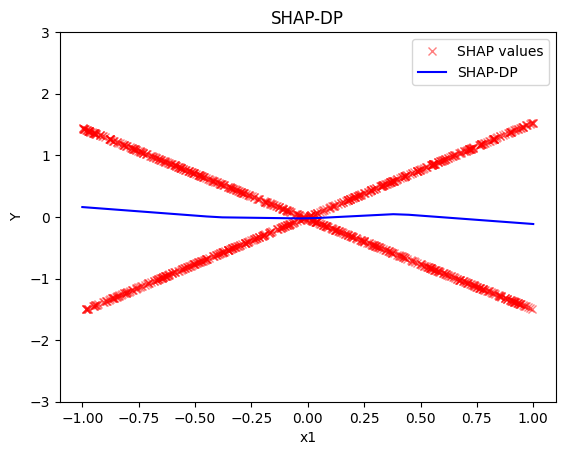

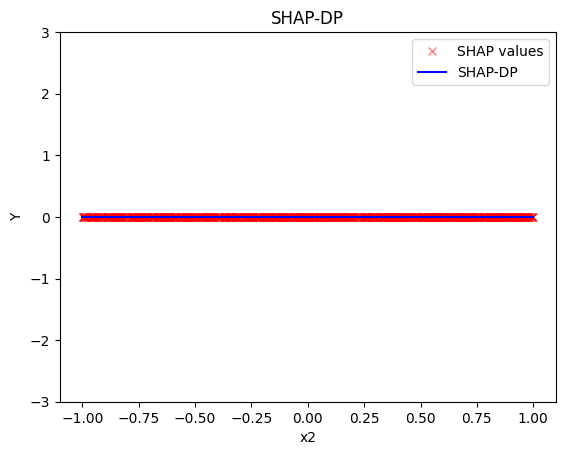

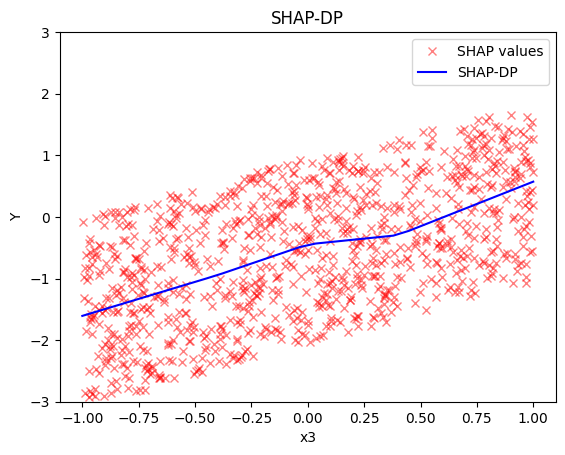

In [5]:
shap = effector.ShapDP(data=X_uncor, model=model, feature_names=['x1','x2','x3'], target_name="Y")
shap.fit(features="all", centering=True, binning_method=effector.axis_partitioning.Fixed(nof_bins=5, min_points_per_bin=0.))
shap.plot(feature=0, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=1, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=2, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])

#### Regional SHAP-DP

In [6]:
regional_shap = effector.RegionalShapDP(
    data=X_uncor, 
    model=model, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

space_partitioner = effector.partitioning.Regions(heter_pcg_drop_thres=0.6, nof_candidate_splits_for_numerical=10)
regional_shap.fit(
    features="all",
    space_partitioner=space_partitioner,
    binning_method=effector.axis_partitioning.Fixed(nof_bins=5, min_points_per_bin=0.)
)

100%|██████████| 3/3 [00:00<00:00,  4.90it/s]


In [7]:
regional_shap.summary(0)



Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 0.85 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x1 | x3 <= 0.0, heter: 0.04 || nof_instances:  1000 || weight: 1.00
        Node id: 2, name: x1 | x3  > 0.0, heter: 0.02 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 0.85
        Level 1, heter: 0.06 || heter drop : 0.80 (units), 93.03% (pcg)




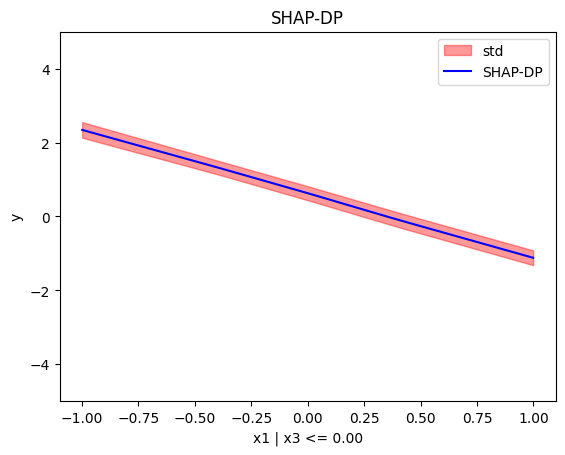

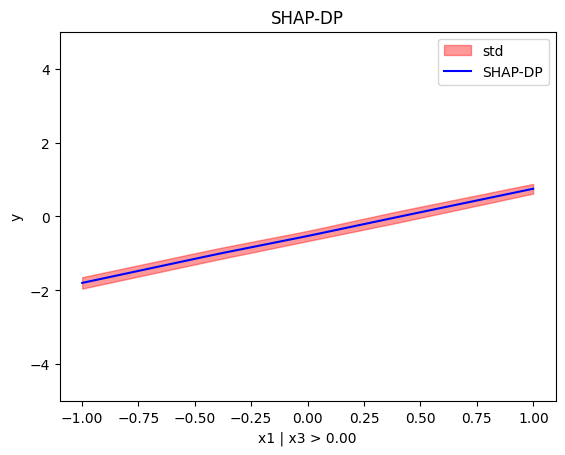

In [8]:
regional_shap.plot(feature=0, node_idx=1, heterogeneity="std", centering=True, y_limits=[-5, 5])
regional_shap.plot(feature=0, node_idx=2, heterogeneity="std", centering=True, y_limits=[-5, 5])

In [9]:
regional_shap.summary(features=1)



Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.00 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.00




In [10]:
regional_shap.summary(features=2)



Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.72 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.72




#### Conclusion

Global SHAP-DP:

   * the average effect of $x_1$ is $0$ with some heterogeneity implied by the interaction with $x_1$. The heterogeneity is expressed with two opposite lines; $-3x_1$ when $x_1 \leq 0$ and $3x_1$ when $x_1 >0$
   * the average effect of $x_2$ to be $0$ without heterogeneity
   * the average effect of $x_3$ to be $x_3$ with some heterogeneity due to the interaction with $x_1$. In contrast with other methods, SHAP spread the heterogeneity along the x-axis.
  
Regional SHAP-DP:


### Correlated setting

#### Global SHAP-DP

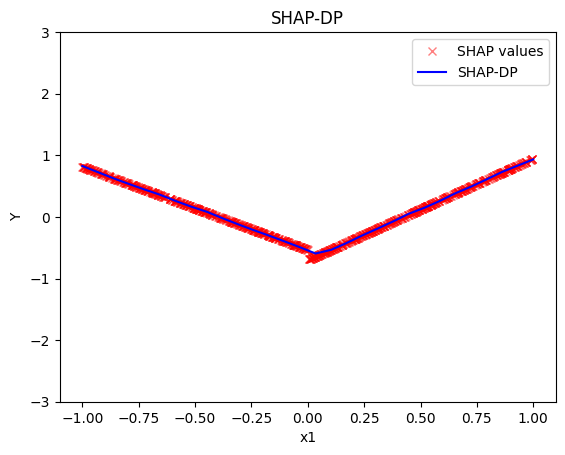

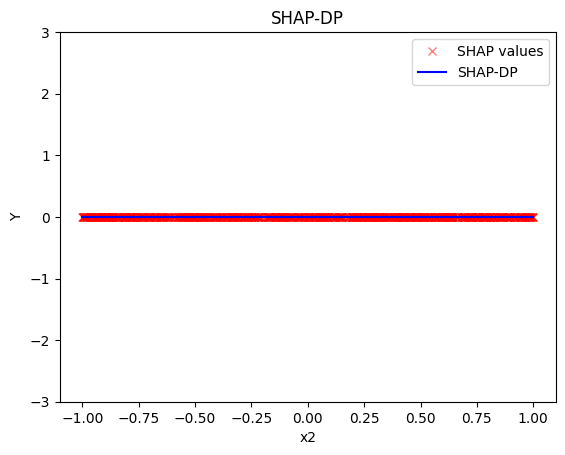

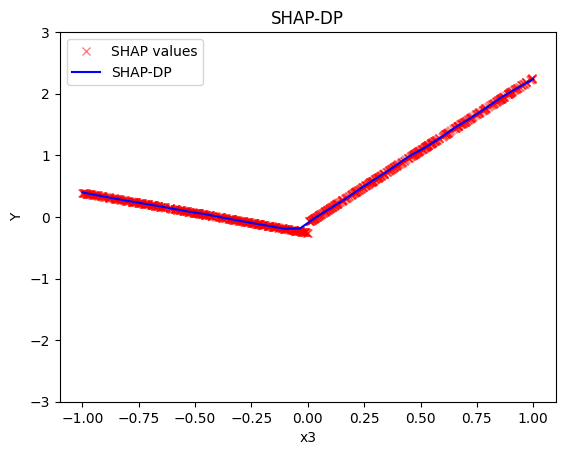

In [11]:
shap = effector.ShapDP(data=X_cor, model=model, feature_names=['x1','x2','x3'], target_name="Y")

shap.plot(feature=0, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=1, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=2, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])

#### Regional SHAP

In [12]:
regional_shap = effector.RegionalShapDP(
    data=X_cor, 
    model=model, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

space_partitioner = effector.partitioning.Regions(heter_pcg_drop_thres=0.6, nof_candidate_splits_for_numerical=10)
regional_shap.fit(
    features="all",
    space_partitioner=space_partitioner,
 )


  0%|          | 0/3 [00:00<?, ?it/s]/home/givasile/miniconda3/envs/effector-dev/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/givasile/miniconda3/envs/effector-dev/lib/python3.10/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/givasile/miniconda3/envs/effector-dev/lib/python3.10/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


In [13]:
regional_shap.summary(0)



Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 0.00 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 0.00




In [14]:
regional_shap.summary(1)



Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.00 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.00




In [15]:
regional_shap.summary(2)



Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.00 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.00




#### Conclusion

